# Data Visualization Analysis

In the data visualization analysis phase, we will conduct a multi-dimalesional exploration of the cleaned data, aiming to reveal preference differences across genders and the intrinsic patterns of fragrance structures. Based on the aforemaletioned data processing results, we have constructed a series of visualization charts, focusing on the following three dimalesions for analysis:

1.  **Market Composition & Gender Preferences**:
    Combining stacked bar charts, sunburst charts, and heatmaps, we analyze the distribution of perfume types (such as Floral, Woody, and Fresh) in the male, female, and neutral perfume markets, as well as the preference intensity of different gender groups for specific perfume types.

2.  **Core Ingredients & Market Penetration**:
    Utilizing bar charts and word clouds, we identify the top 20 core ingredients with the highest market penetration. Furthermore, we perform a segmaleted analysis of **Top, Middle, and Base notes** to reveal the dominant olfactory elemalets at each stage of a perfume's structure.

3.  **Olfactory Structure & Complexity**:
    Using Sankey diagrams to visualize the flow path of perfumes from Top, Middle to Base notes, **revealing the unique structural aesthetics of Male, Female, and Neutral perfumes**, and employing boxplots to explore the formula complexity (note richness) of different perfume types.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
from collections import Counter
from sklearn.manifold import TSNE
import warnings
import re
from itertools import combinations
from wordcloud import WordCloud
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = ['DejaVu Sans', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

data_dir = 'data/'
df_fragrance_count = pd.read_csv(data_dir + 'fragrance_count.csv') 
df_1976 = pd.read_csv(data_dir + '1976_clean.csv') 
df_note_count = pd.read_csv(data_dir + 'note_type_map.csv') 
df_fragrance_map = pd.read_csv(data_dir + 'fragrance_map.csv') 

fragrance_map = dict(zip(df_fragrance_map['original_fragrance'], df_fragrance_map['fragrance']))
df_1976['fragrance'] = df_1976['fragrance'].map(fragrance_map).fillna(df_1976['fragrance'])

note_class_map = pd.Series(df_note_count['class'].values, index=df_note_count['note']).to_dict()

for note in note_class_map:
    if pd.isna(note_class_map[note]):
        note_class_map[note] = '其他'

class_trans = {
    '花香调': '花香调\nFloral', '木质调': '木质调\nWoody', '东方调': '东方调\nOriental', '柑橘调': '柑橘调\nCitrus',
    '果香调': '果香调\nFruity', '馥奇调': '馥奇调\nFougère', '绿叶调': '绿叶调\nGreen', '水生调': '水生调\nAquatic',
    '甘苔调': '甘苔调\nChypre', '皮革调': '皮革调\nLeather', '美食调': '美食调\nGourmand', '辛香调': '辛香调\nSpicy',
    '醛香调': '醛香调\nAldehyde', '素心兰调': '素心兰调\nChypre', '清新调': '清新调\nFresh', '其他': '其他\nOther',
    '男性': 'Male', '女性': 'Female', '中性': 'Neutral',
    'male': 'Male', 'female': 'Female', 'neutral': 'Neutral',
    '木质香调': '木质调\nWoody', '美食香调': '美食调\nGourmand', '皮革香调': '皮革调\nLeather', 
    '青香调': '绿叶调\nGreen', '海洋调': '水生调\nAquatic', '麝香调': '麝香调\nMusk', 
    '柑苔香调': '甘苔调\nChypre', '树脂调': '树脂调\nResinous', '概念性': '概念性\nConceptual'
}

## Market Composition & Gender Distribution

Through the analysis of 2103 perfume products, we first examined the overall market composition and the distribution of perfume types across different gender positionings.

**Market Share Overview:**
According to our dataset, **Female Perfumes** dominate the market, accounting for approximately 48% of the total; followed by **Male Perfumes**, accounting for about 32%; while **Neutral (neutral) Perfumes** occupy a share of around 20%.

**Fragrance Preference Differences:**
*   **Female Market**: **Floral Notes** hold absolute dominance in female perfumes, occupying 41% of the female perfume market. The heatmap visualization further confirms this highly concentrated preference, indicating female consumers' fondness for soft, romantic, and sweet scents.
*   **Male Market**: **Woody Notes** dominate (45%), closely followed by **Fresh Notes** (36%). This forms a distinct "dual-core" pattern in our analysis, balancing maturity and vitality. Woody notes typically represent a steady temperamalet, suitable for composed, mature male. Fresh notes, on the other hand, focus on cleanliness and energy, making them more suitable for outgoing, lively young male.
*   **Neutral Market**: The distribution is relatively balanced, but **Fresh Notes** (35%) and **Woody Notes** (31%) remain the most popular choices. We can conclude that woody and fresh notes are more capable of transcending gender boundaries and gaining favor from both sexes simultaneously.

The figures below display the hierarchical distribution of market composition, the specific quantity distribution of each perfume type across different genders, and the preference intensity of different genders for various perfume types:

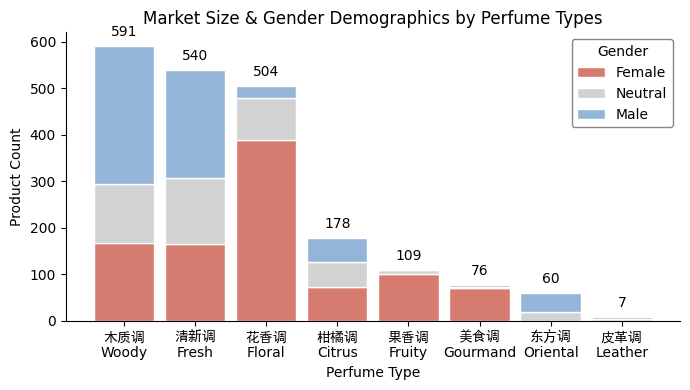

In [2]:
# Perfume Types Distribution by Gender

plt.figure(figsize=(7, 4))

valid_genders = ['male', 'female', 'neutral']
df_stack = df_1976[df_1976['gender'].isin(valid_genders)].copy()

df_stack['fragrance_en'] = df_stack['fragrance'].map(class_trans).fillna(df_stack['fragrance'])

ct_stack = pd.crosstab(df_stack['fragrance_en'], df_stack['gender'])

ct_stack['Total'] = ct_stack.sum(axis=1)
ct_stack = ct_stack.sort_values('Total', ascending=False)

categories = ct_stack.index
genders_order = ['female', 'neutral', 'male'] 
data_bottom = np.zeros(len(categories))

colors = {'female': '#D57B70', 'neutral': '#D2D2D2', 'male': '#94B5D8'}
labels = {'female': 'Female', 'neutral': 'Neutral', 'male': 'Male'}

for gender in genders_order:
    if gender in ct_stack.columns:
        values = ct_stack[gender].values
        plt.bar(categories, values, bottom=data_bottom, label=labels[gender], 
                color=colors[gender], edgecolor='white', width=0.85, linewidth=1)
        data_bottom += values

plt.title('Market Size & Gender Demographics by Perfume Types')
plt.xlabel('Perfume Type')
plt.ylabel('Product Count')

plt.legend(title='Gender', loc='upper right', frameon=True, framealpha=0.95, shadow=False, edgecolor='gray')

for i, total in enumerate(ct_stack['Total']):
    plt.text(i, total + 15, f"{int(total)}", ha='center', va='bottom')

plt.grid(False)
sns.despine()
plt.tight_layout()
plt.savefig("img/Market Size & Gender Demographics by Perfume Types.png", dpi=300)
plt.show()

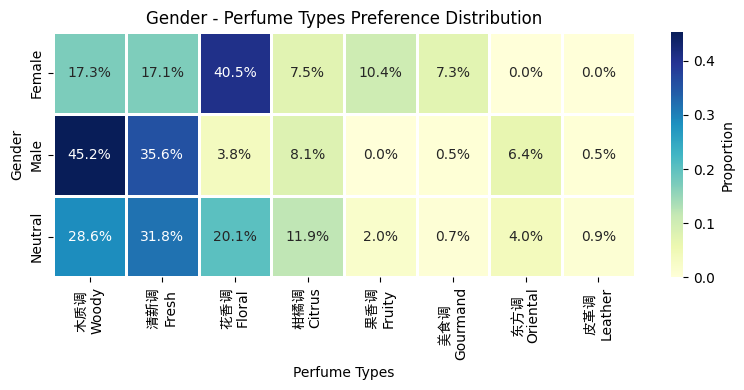

In [3]:
# Gender-Fragrance Heatmap
valid_genders = ['male', 'female', 'neutral']
df_heatmap = df_1976[df_1976['gender'].isin(valid_genders)].copy()

df_heatmap['fragrance_en'] = df_heatmap['fragrance'].map(class_trans).fillna(df_heatmap['fragrance'])
df_heatmap['gender_en'] = df_heatmap['gender'].map(class_trans).fillna(df_heatmap['gender'])

ct = pd.crosstab(df_heatmap['gender_en'], df_heatmap['fragrance_en'], normalize='index')

col_order = df_heatmap['fragrance_en'].value_counts().index
col_order = [c for c in col_order if c in ct.columns]
ct_sorted = ct[col_order]

plt.figure(figsize=(8, 4)) 

sns.heatmap(ct_sorted, annot=True, fmt='.1%', cmap='YlGnBu', 
            cbar_kws={'label': 'Proportion'},
            linewidths=1.0, linecolor='white')

plt.title('Gender - Perfume Types Preference Distribution')
plt.xlabel('Perfume Types')
plt.ylabel('Gender')

plt.tight_layout()
plt.savefig("img/Gender-Perfume Types Preference Distribution.png", dpi=300)
plt.show()

In [4]:
#  Market Composition Sunburst
df_sunburst = df_1976[df_1976['gender'].isin(['male', 'female', 'neutral'])].copy()

simple_trans_map = {k: v.split('\n')[0] + ' ' + v.split('\n')[1] for k, v in class_trans.items() if '\n' in v}
simple_trans_map.update({'male': 'Male', 'female': 'Female', 'neutral': 'Neutral'})

df_sunburst['gender_en'] = df_sunburst['gender'].map(simple_trans_map).fillna(df_sunburst['gender'])
df_sunburst['fragrance_en'] = df_sunburst['fragrance'].map(simple_trans_map).fillna(df_sunburst['fragrance'])

df_sb_count = df_sunburst.groupby(['gender_en', 'fragrance_en']).size().reset_index(name='count')
df_sb_count = df_sb_count[df_sb_count['count'] > 20]

fig = px.sunburst(
    df_sb_count, 
    path=['gender_en', 'fragrance_en'], 
    values='count',
    color='gender_en',
    color_discrete_map={
        'Female': '#D57B70',
        'Neutral': '#D2D2D2',
        'Male': '#94B5D8',
        '(?)': '#D2D2D2'
    },
    title='Market Composition Hierarchy'
)

fig.update_layout(
    width=600,
    height=600,
    margin=dict(t=80, l=10, r=10, b=10),
    font_size=16,
    template='plotly_white',
    title={'text': 'Market Composition Hierarchy', 'x': 0.5, 'xanchor': 'center'}
)
fig.update_traces(textinfo="label+percent parent")

fig.write_image("img/Market Composition Hierarchy.png", scale=3)
fig.show()


## Core Ingredients & Market Penetration

In this section, we delve into the specific ingredients that make up these perfumes. In addition to calculating the frequency of each note across the entire dataset, we conducted a segmaleted analysis of the perfume's three-note structure (Top, Middle, and Base notes) to reveal the dominant scents at different stages.

The analysis results indicate that **Musk** is the undisputed "King of Ingredients," appearing in 2103 perfumes. It predominantly appears as a **Base Note**, providing depth and longevity to the fragrance.

Through the breakdown analysis of the three notes (Dominant Ingredients Analysis), we discovered clear structural patterns:
*   **Top Notes**: **Bergamot** (601 counts) and **Citrus** (310 counts) hold absolute dominance. Fresh, volatile citrus notes are the top choice for opening the olfactory experience, with Lemon and Pink Pepper also being common top note elemalets.
*   **Middle Notes**: Floral notes dominate the core experience. **Jasmine** (372 counts) and **Rose** (259 counts) are the most classic middle note choices, followed closely by **Neroli** and **Lavender**, constructing the main character of the perfume.
*   **Base Notes**: Besides **Musk**, **Patchouli**, **Amber**, and **Cedar** all have extremely high frequencies (400+ counts), forming the warm, woody foundation of modern perfumes.

**Keyword Cloud Analysis:**
The word cloud visualization intuitively displays the relative weight of these ingredients. We can see that in addition to the core ingredients maletioned above, elemalets like **Vanilla** and **Tonka Bean** also have significant visibility. This combination reveals a market trend: consumers generally prefer perfumes with a fresh opening (Bergamot/Citrus), a rich floral heart (Jasmine/Rose), and a warm, steady base (Musk/Woody/Amber).

The figures below display the ranking of the Top 20 ingredients, the detailed distribution of ingredients across the three notes, and the word cloud of overall ingredient frequency:


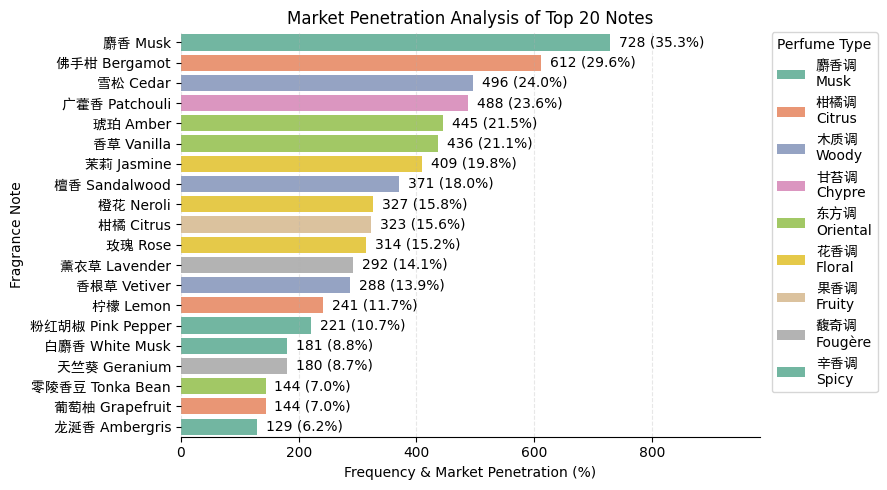

In [5]:
# Note Frequency Top-K - Market Penetration Analysis

top_k = 20
total_perfumes = len(df_1976) 

df_top_notes = df_note_count.sort_values('count', ascending=False).head(top_k).copy()

note_trans = {
    '麝香': '麝香 Musk', '佛手柑': '佛手柑 Bergamot', '雪松': '雪松 Cedar', 
    '广藿香': '广藿香 Patchouli', '琥珀': '琥珀 Amber', '香草': '香草 Vanilla', 
    '茉莉': '茉莉 Jasmine', '檀香': '檀香 Sandalwood', '橙花': '橙花 Neroli', 
    '柑橘': '柑橘 Citrus', '玫瑰': '玫瑰 Rose', '薰衣草': '薰衣草 Lavender', 
    '香根草': '香根草 Vetiver', '柠檬': '柠檬 Lemon', '粉红胡椒': '粉红胡椒 Pink Pepper', 
    '白麝香': '白麝香 White Musk', '天竺葵': '天竺葵 Geranium', '零陵香豆': '零陵香豆 Tonka Bean', 
    '葡萄柚': '葡萄柚 Grapefruit', '龙涎香': '龙涎香 Ambergris'
}
df_top_notes['note_en'] = df_top_notes['note'].map(note_trans).fillna(df_top_notes['note'])

df_top_notes['class'] = df_top_notes['class'].fillna('Other')
df_top_notes['class_en'] = df_top_notes['class'].map(class_trans).fillna(df_top_notes['class'])

df_top_notes['percentage'] = df_top_notes['count'] / total_perfumes * 100 

plt.figure(figsize=(9, 5)) 

ax = sns.barplot(data=df_top_notes, y='note_en', x='count', hue='class_en', dodge=False, palette='Set2')

plt.title(f'Market Penetration Analysis of Top {top_k} Notes')
plt.xlabel('Frequency & Market Penetration (%)')
plt.ylabel('Fragrance Note')

plt.legend(title='Perfume Type', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=True)

for i, p in enumerate(ax.patches):
    width = p.get_width()
    if width > 0: 
        percentage = (width / total_perfumes) * 100
        label_text = f'{int(width)} ({percentage:.1f}%)'
        ax.text(width + 15, p.get_y() + p.get_height()/2.,
                label_text,
                ha='left', va='center', color='black')

max_width = df_top_notes['count'].max()
plt.xlim(0, max_width * 1.35)

plt.grid(axis='x', linestyle='--', alpha=0.3)
sns.despine(left=True, bottom=False)

plt.tight_layout()
plt.savefig("img/Top-K Note Frequency Market Penetration Analysis.png", dpi=300)
plt.show()

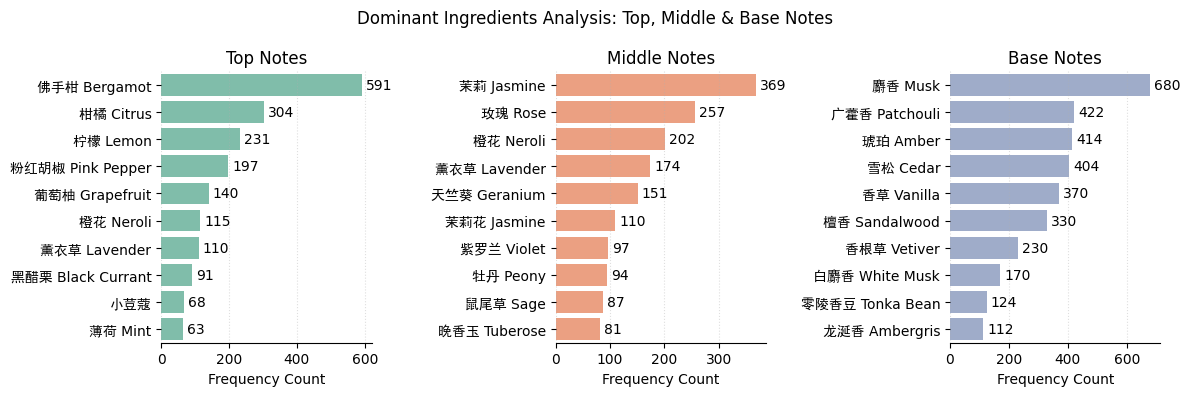

In [6]:
# Top 10 Notes Distribution by Olfactory Pyramid Position

def get_note_counts(df, column):
    all_notes = []
    for notes in df[column].dropna():
        cleaned = notes.replace('、', ',').replace(' ', '')
        all_notes.extend([n.strip() for n in cleaned.split(',') if n.strip()])
    return pd.Series(Counter(all_notes)).sort_values(ascending=False)

top_counts = get_note_counts(df_1976, 'top_notes').head(10)
mid_counts = get_note_counts(df_1976, 'middle_notes').head(10)
base_counts = get_note_counts(df_1976, 'base_notes').head(10)

note_trans_map = {
    '麝香': '麝香 Musk', '佛手柑': '佛手柑 Bergamot', '雪松': '雪松 Cedar', 
    '广藿香': '广藿香 Patchouli', '琥珀': '琥珀 Amber', '香草': '香草 Vanilla', 
    '茉莉': '茉莉 Jasmine', '檀香': '檀香 Sandalwood', '橙花': '橙花 Neroli', 
    '柑橘': '柑橘 Citrus', '玫瑰': '玫瑰 Rose', '薰衣草': '薰衣草 Lavender', 
    '香根草': '香根草 Vetiver', '柠檬': '柠檬 Lemon', '粉红胡椒': '粉红胡椒 Pink Pepper', 
    '白麝香': '白麝香 White Musk', '天竺葵': '天竺葵 Geranium', '零陵香豆': '零陵香豆 Tonka Bean', 
    '葡萄柚': '葡萄柚 Grapefruit', '龙涎香': '龙涎香 Ambergris', '依兰': '依兰 Ylang-Ylang',
    '紫罗兰': '紫罗兰 Violet', '鸢尾花': '鸢尾花 Iris', '橡木苔': '橡木苔 Oakmoss',
    '安息香': '安息香 Benzoin', '皮革': '皮革 Leather', '黑胡椒': '黑胡椒 Black Pepper',
    '肉豆蔻': '肉豆蔻 Nutmeg', '小豆蔻': '小豆蔻 Cardamom', '生姜': '生姜 Ginger',
    '薄荷': '薄荷 Mint', '罗勒': '罗勒 Basil', '鼠尾草': '鼠尾草 Sage',
    '百合': '百合 Lily', '铃兰': '铃兰 Lily of the Valley', '晚香玉': '晚香玉 Tuberose',
    '桃子': '桃子 Peach', '苹果': '苹果 Apple', '黑醋栗': '黑醋栗 Black Currant',
    '梨': '梨 Pear', '菠萝': '菠萝 Pineapple', '椰子': '椰子 Coconut',
    '橘子': '橘子 Mandarin', '沉香': '沉香 Oud', '劳丹脂': '劳丹脂 Labdanum',
    '牡丹': '牡丹 Peony', '小苍兰': '小苍兰 Freesia', '香柠檬': '香柠檬 Bergamot',
    '茉莉花': '茉莉花 Jasmine', '檀香木': '檀香木 Sandalwood', '檀木': '檀木 Sandalwood',
    '雪松木': '雪松木 Cedar', '橡苔': '橡苔 Oakmoss', '乳香': '乳香 Frankincense',
    '没药': '没药 Myrrh', '鸢尾': '鸢尾 Iris', '水蜜桃': '水蜜桃 Peach',
    '杏': '杏 Apricot', '黑加仑': '黑加仑 Blackcurrant', '肉桂': '肉桂 Cinnamon',
    '丁香': '丁香 Clove', '芫荽': '芫荽 Coriander', '丝柏': '丝柏 Cypress',
    '尤加利': '尤加利 Eucalyptus', '无花果': '无花果 Fig', '栀子花': '栀子花 Gardenia',
    '风信子': '风信子 Hyacinth', '杜松子': '杜松子 Juniper Berry', '青柠': '青柠 Lime',
    '木兰': '木兰 Magnolia', '苔藓': '苔藓 Moss', '桂花': '桂花 Osmanthus',
    '李子': '李子 Plum', '藏红花': '藏红花 Saffron', '烟草': '烟草 Tobacco',
    '柚子': '柚子 Yuzu', '香柠檬': '香柠檬 Bergamot'
}

positions = ['Top Notes', 'Middle Notes', 'Base Notes']
data_list = [top_counts, mid_counts, base_counts]

colors = ['#66C2A5', '#FC8D62', '#8DA0CB'] 

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plt.subplots_adjust(wspace=0.4)

for i, (ax, data, title, color) in enumerate(zip(axes, data_list, positions, colors)):
    labels = [note_trans_map.get(n, n) for n in data.index]

    bars = sns.barplot(x=data.values, y=labels, ax=ax, color=color, alpha=0.9)

    ax.set_title(title)
    ax.set_xlabel('Frequency Count')
    ax.tick_params(axis='y')
    ax.tick_params(axis='x')

    for p in ax.patches:
        width = p.get_width()
        ax.text(width + max(data.values)*0.02, p.get_y() + p.get_height()/2, 
                f'{int(width)}', ha='left', va='center')
    
    # Remove borders
    sns.despine(left=True, bottom=False, ax=ax)
    
    # Add light grid for readability
    ax.grid(axis='x', linestyle=':', alpha=0.4)
    ax.set_ylabel('') # Remove y-label as it's self-explanatory

plt.suptitle('Dominant Ingredients Analysis: Top, Middle & Base Notes')
plt.tight_layout()
plt.savefig("img/Dominant Ingredients Analysis Top Middle Base Notes.png", dpi=400)
plt.show()

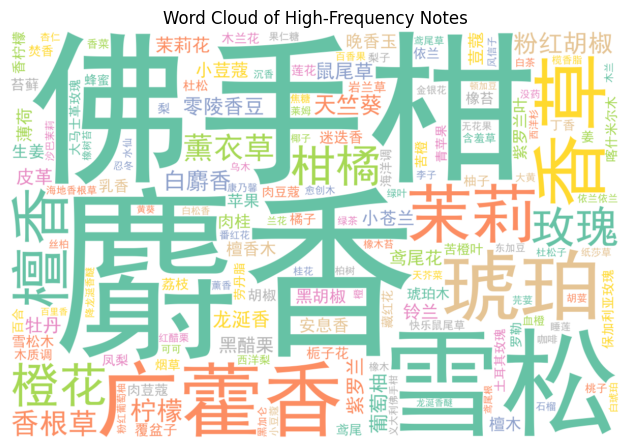

In [7]:
# Note Word Cloud
from wordcloud import WordCloud
import os

frequencies = df_note_count.set_index('note')['count'].to_dict()

font_path = 'C:/Windows/Fonts/simhei.ttf'
if not os.path.exists(font_path):
    import matplotlib.font_manager
    try:
        font_path = matplotlib.font_manager.findfont(matplotlib.font_manager.FontProperties(family=['SimHei']))
    except:
        font_path = None 

wc = WordCloud(
    font_path=font_path,
    background_color='white',
    width=1200,
    height=800,
    max_words=150,
    colormap='Set2',
    random_state=42,
    prefer_horizontal=0.9
)

wc.generate_from_frequencies(frequencies)

plt.figure()
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of High-Frequency Notes')
plt.tight_layout()
plt.savefig("img/Word Cloud of High-Frequency Notes.png", dpi=400)
plt.show()

## Olfactory Structure & Complexity

Finally, we turn our attention to the internal structure of perfumes, using Sankey Diagrams and Boxplots to explore the flow path of scents and formula complexity.

**Olfactory Flow Path:**
The Sankey diagram vividly illustrates the evolutionary logic of perfumes from **Top -> Middle -> Base notes**.
*   **Classic Path**: The most prominent flow path starts with **Citrus/Fruity** notes, transitions to a **Floral** core, and finally settles into a **Musk/Woody** base. This "Fresh-Soft-Warm" three-stage structure constitutes the mainstream skeleton of modern commercial perfumes.
*   **Structural Differences**: We observe that male perfumes tend towards the hard lines of "Citrus -> Aromatic/Spicy -> Woody", while female perfumes present more of the soft curves of "Fruity -> Floral -> Musk/Amber".
*   **Neutral Aesthetics**: Neutral perfumes showcase a unique beauty of balance, often opening with fresh **Citrus** or **Green** notes, blending **Floral** and **Woody** characteristics in the middle, and finally returning to the steadiness of **Musk** or **Woody** notes, breaking the traditional olfactory boundaries of gender.

**Formula Complexity:**
We measure "complexity" by calculating the number of ingredients contained in each perfume and use boxplots to compare the formula richness of different fragrance families.
*   **Spectrum of Complexity**: **Chypre** and **Oriental** notes typically possess the highest median number of ingredients, representing the traditional aesthetic of grand structures and rich layers.
*   **Minimalism**: In contrast, **Fresh** notes or single floral perfumes have simpler formulas, emphasizing the purity of a single elemalet.
*   **Dispersion**: The distribution range of the boxplot also reveals that certain fragrance families (such as Woody notes) have great elasticity in formula complexity, ranging from minimalist modern works to complex classical pieces.

The figures below display the Sankey diagram of the three-note flow and the complexity distribution of different fragrance types:


In [8]:
# Sankey Diagram - Olfactory Pyramid Structure Analysis

def get_dominant_class_en(notes_str):
    if pd.isna(notes_str): return None
    notes = [n.strip() for n in notes_str.replace('、', ',').split(',')]
    classes = [note_class_map.get(n, '其他') for n in notes]
    if not classes: return 'Other'
    dom_class = Counter(classes).most_common(1)[0][0]
    trans_map = {
        '花香调': '花香调 Floral', '木质调': '木质调 Woody', '东方调': '东方调 Oriental', 
        '柑橘调': '柑橘调 Citrus', '果香调': '果香调 Fruity', '馥奇调': '馥奇调 Fougère', 
        '绿叶调': '绿叶调 Green', '水生调': '水生调 Aquatic', '甘苔调': '甘苔调 Chypre', 
        '皮革调': '皮革调 Leather', '美食调': '美食调 Gourmand', '辛香调': '辛香调 Spicy',
        '醛香调': '醛香调 Aldehyde', '素心兰调': '素心兰调 Chypre', '清新调': '清新调 Fresh', 
        '其他': '其他 Other',
        '木质香调': '木质调 Woody', '美食香调': '美食调 Gourmand', '皮革香调': '皮革调 Leather', 
        '青香调': '青香调 Green', '海洋调': '海洋调 Marine', '麝香调': '麝香调 Musk', 
        '柑苔香调': '柑苔调 Chypre', '树脂调': '树脂调 Resinous', '概念性': '概念性 Conceptual'
    }
    if dom_class not in trans_map and dom_class in class_trans:
        val = class_trans[dom_class]
        if '\n' in val:
            trans_map[dom_class] = val.replace('\n', ' ')
    return trans_map.get(dom_class, dom_class)

sankey_data = []
for _, row in df_1976.iterrows():
    top = get_dominant_class_en(row['top_notes'])
    mid = get_dominant_class_en(row['middle_notes'])
    base = get_dominant_class_en(row['base_notes'])
    if top and mid:
        sankey_data.append({'source': f"Top: {top}", 'target': f"Mid: {mid}", 'value': 1})
    if mid and base:
        sankey_data.append({'source': f"Mid: {mid}", 'target': f"Base: {base}", 'value': 1})

df_sankey = pd.DataFrame(sankey_data)
df_sankey = df_sankey.groupby(['source', 'target']).count().reset_index()
df_sankey = df_sankey[df_sankey['value'] > 30] 

all_nodes = list(pd.concat([df_sankey['source'], df_sankey['target']]).unique())
node_map = {node: i for i, node in enumerate(all_nodes)}
node_colors = ["#66c2a5" if "Top" in n else "#fc8d62" if "Mid" in n else "#8da0cb" for n in all_nodes]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 20,
      thickness = 30,
      line = dict(color = "black", width = 0.5),
      label = all_nodes,
      color = node_colors
    ),
    link = dict(
      source = [node_map[s] for s in df_sankey['source']],
      target = [node_map[t] for t in df_sankey['target']],
      value = df_sankey['value'],
      color = "rgba(200, 200, 200, 0.5)" 
  ))])

fig.update_layout(
    title={'text': "Structural Analysis of Olfactory Pyramid Flow", 'x': 0.5, 'xanchor': 'center'},
    font_size=16,
    width=900,
    height=600,
    template='plotly_white',
    margin=dict(t=60, l=10, r=10, b=10)
)
fig.write_image("img/Olfactory_Pyramid_Sankey.png", scale=3)
fig.show()

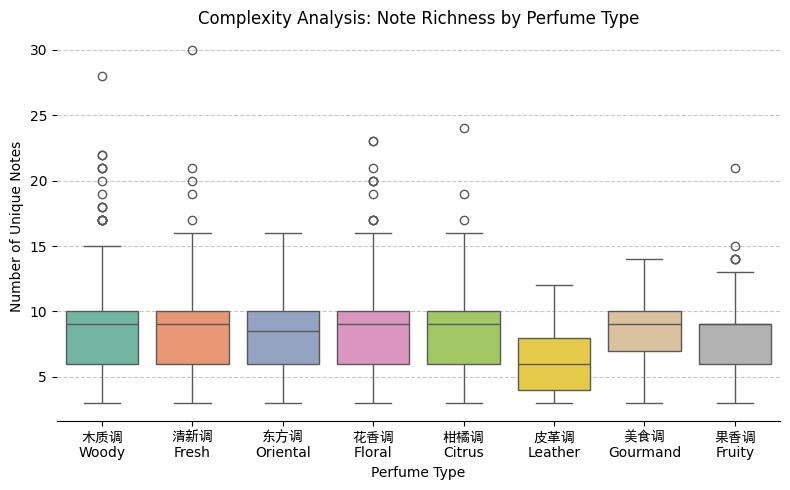

In [9]:
# Note Richness vs Fragrance Type

def count_notes(row):
    notes = []
    for col in ['top_notes', 'middle_notes', 'base_notes']:
        if pd.notna(row[col]):
            notes.extend(row[col].replace('、', ',').split(','))
    return len(set(notes))

df_1976['note_count'] = df_1976.apply(count_notes, axis=1)
df_1976['fragrance_en'] = df_1976['fragrance'].map(class_trans).fillna(df_1976['fragrance'])

top_fragrances = df_1976['fragrance_en'].value_counts().head(12).index
df_box = df_1976[df_1976['fragrance_en'].isin(top_fragrances)]

plt.figure(figsize=(8, 5))

sns.boxplot(x='fragrance_en', y='note_count', data=df_box, palette="Set2")

plt.title('Complexity Analysis: Note Richness by Perfume Type')
plt.xlabel('Perfume Type')
plt.ylabel('Number of Unique Notes')

plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(left=True)
plt.tight_layout()
plt.savefig("img/Complexity Analysis Note Richness by Fragrance Family.png", dpi=300)
plt.show()

In [10]:
# Gender-Specific Sankey Diagrams
def plot_gender_sankey(target_gender, title_text, threshold=15, filename=None):
    df_gender = df_1976[df_1976['gender'] == target_gender]
    
    sankey_data = []
    for _, row in df_gender.iterrows():
        top = get_dominant_class_en(row['top_notes'])
        mid = get_dominant_class_en(row['middle_notes'])
        base = get_dominant_class_en(row['base_notes'])
        
        if top and mid:
            sankey_data.append({'source': f"Top: {top}", 'target': f"Mid: {mid}", 'value': 1})
        if mid and base:
            sankey_data.append({'source': f"Mid: {mid}", 'target': f"Base: {base}", 'value': 1})

    if not sankey_data:
        print(f"No data for {target_gender}")
        return

    df_sankey = pd.DataFrame(sankey_data)
    df_sankey = df_sankey.groupby(['source', 'target']).count().reset_index()
    df_sankey = df_sankey[df_sankey['value'] > threshold] 

    all_nodes = list(pd.concat([df_sankey['source'], df_sankey['target']]).unique())
    node_map = {node: i for i, node in enumerate(all_nodes)}

    node_colors = ["#66c2a5" if "Top" in n else "#fc8d62" if "Mid" in n else "#8da0cb" for n in all_nodes]

    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 12,
          thickness = 22,
          line = dict(color = "black", width = 0.3),
          label = all_nodes,
          color = node_colors
        ),
        link = dict(
          source = [node_map[s] for s in df_sankey['source']],
          target = [node_map[t] for t in df_sankey['target']],
          value = df_sankey['value'],
          color = "rgba(200, 200, 200, 0.5)" 
      ))])

    fig.update_layout(
        title={'text': title_text, 'x': 0.5, 'xanchor': 'center'},
        font_size=14,
        width=700,
        height=480,
        template='plotly_white',
        margin=dict(t=50, l=5, r=5, b=5)
    )
    if filename:
        fig.write_image(filename, scale=3)
    fig.show()

# Plot for Male
plot_gender_sankey('male', "Olfactory Structure Flow - Male Perfumes", threshold=10, filename="img/sankey_male.png")

# Plot for Female
plot_gender_sankey('female', "Olfactory Structure Flow - Female Perfumes", threshold=20, filename="img/sankey_female.png")

# Plot for Neutral
plot_gender_sankey('neutral', "Olfactory Structure Flow - Neutral Perfumes", threshold=10, filename="img/sankey_neutral.png")

## Price Analysis and Visualization

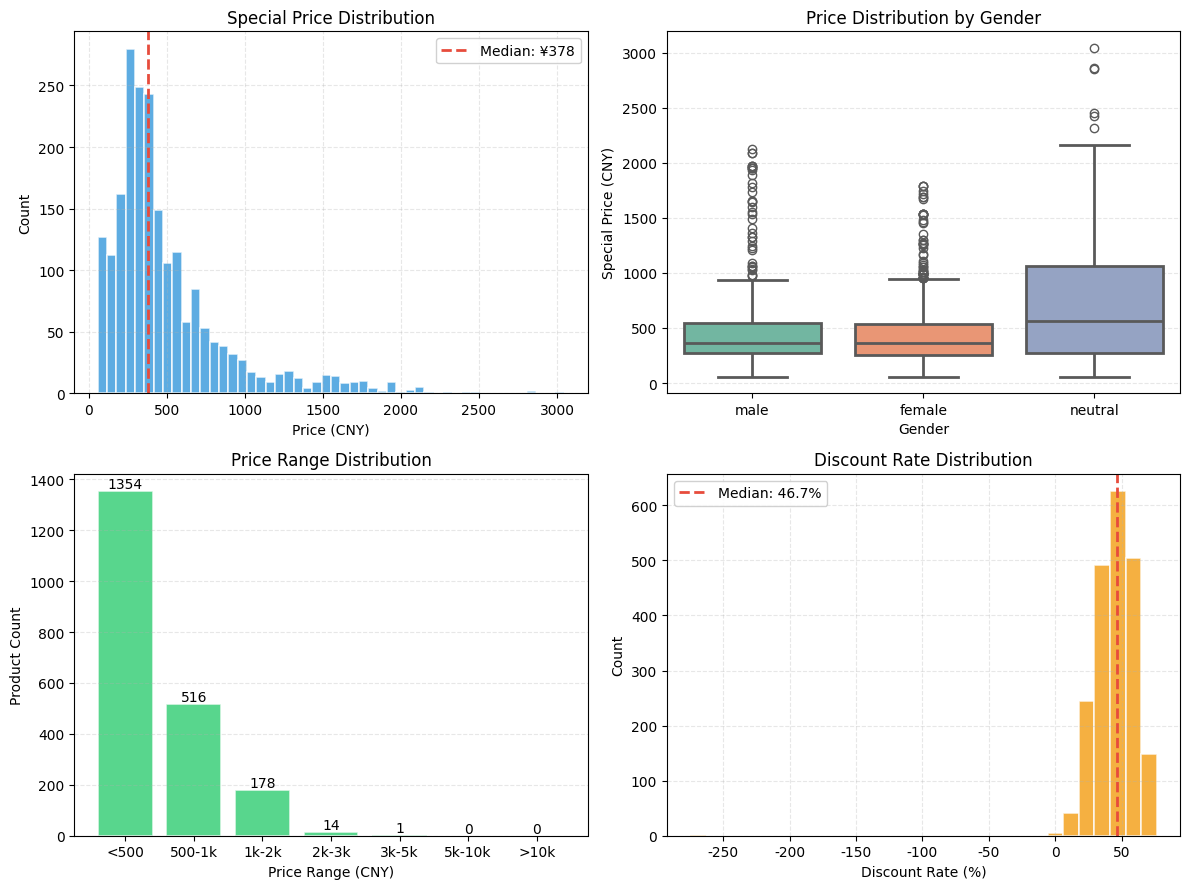

In [11]:
df = pd.read_csv('data/1976_clean.csv')

# Create price analysis charts
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
fig.patch.set_facecolor('white')

# Color palette
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

# 1. Price distribution histogram
axes[0, 0].hist(df['special_price'].dropna(), bins=50, color=colors[0], 
                edgecolor='white', alpha=0.8, linewidth=1.2)
axes[0, 0].set_title('Special Price Distribution')
axes[0, 0].set_xlabel('Price (CNY)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].axvline(df['special_price'].median(), color=colors[1], linestyle='--', 
                    linewidth=2, label=f'Median: ¥{df["special_price"].median():.0f}')
axes[0, 0].legend(framealpha=0.9)
axes[0, 0].grid(True, alpha=0.3, linestyle='--')

# 2. Price boxplot by gender
df_plot = df[df['special_price'].notna()]
bp = sns.boxplot(data=df_plot, x='gender', y='special_price', ax=axes[0, 1], 
                 palette='Set2', linewidth=2)
axes[0, 1].set_title('Price Distribution by Gender')
axes[0, 1].set_xlabel('Gender')
axes[0, 1].set_ylabel('Special Price (CNY)')
axes[0, 1].grid(True, alpha=0.3, linestyle='--', axis='y')

# 3. Price range distribution
price_bins = [0, 500, 1000, 2000, 3000, 5000, 10000, 50000]
price_labels = ['<500', '500-1k', '1k-2k', '2k-3k', '3k-5k', '5k-10k', '>10k']
df['price_range'] = pd.cut(df['special_price'], bins=price_bins, labels=price_labels)
price_range_counts = df['price_range'].value_counts().sort_index()
bars = axes[1, 0].bar(range(len(price_range_counts)), price_range_counts.values, 
                       color=colors[2], alpha=0.8, edgecolor='white', linewidth=1.2)
axes[1, 0].set_xticks(range(len(price_range_counts)))
axes[1, 0].set_xticklabels(price_range_counts.index)
axes[1, 0].set_title('Price Range Distribution')
axes[1, 0].set_xlabel('Price Range (CNY)')
axes[1, 0].set_ylabel('Product Count')
axes[1, 0].grid(True, alpha=0.3, linestyle='--', axis='y')
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')

# 4. Discount rate distribution
axes[1, 1].hist(df['discount_rate'].dropna(), bins=30, color=colors[3], 
                edgecolor='white', alpha=0.8, linewidth=1.2)
axes[1, 1].set_title('Discount Rate Distribution')
axes[1, 1].set_xlabel('Discount Rate (%)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].axvline(df['discount_rate'].median(), color=colors[1], linestyle='--', 
                    linewidth=2, label=f'Median: {df["discount_rate"].median():.1f}%')
axes[1, 1].legend(framealpha=0.9)
axes[1, 1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('img/price_analysis.png', dpi=300)
plt.show()

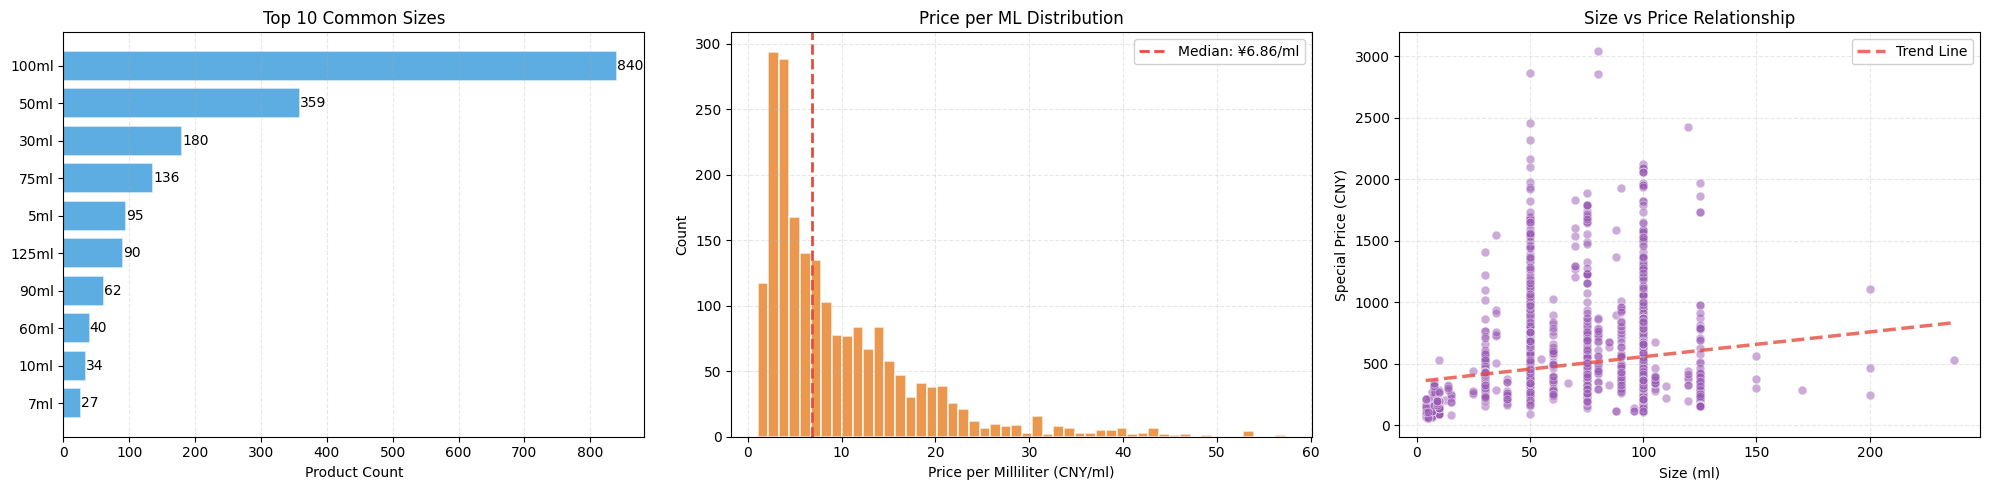

In [12]:
# Specification analysis
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.patch.set_facecolor('white')

# 1. Specification distribution
ml_counts = df['ml'].value_counts().head(10)
bars = axes[0].barh(range(len(ml_counts)), ml_counts.values, color='#3498db', 
                    alpha=0.8, edgecolor='white', linewidth=1.2)
axes[0].set_yticks(range(len(ml_counts)))
axes[0].set_yticklabels([f"{int(ml)}ml" for ml in ml_counts.index])
axes[0].set_title('Top 10 Common Sizes')
axes[0].set_xlabel('Product Count')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, linestyle='--', axis='x')
# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    axes[0].text(width, bar.get_y() + bar.get_height()/2., 
                f'{int(width)}', ha='left', va='center')

# 2. Price per ml distribution
axes[1].hist(df['price_per_ml'].dropna(), bins=50, color='#e67e22', 
            edgecolor='white', alpha=0.8, linewidth=1.2)
axes[1].set_title('Price per ML Distribution')
axes[1].set_xlabel('Price per Milliliter (CNY/ml)')
axes[1].set_ylabel('Count')
axes[1].axvline(df['price_per_ml'].median(), color='#e74c3c', linestyle='--', 
                linewidth=2, label=f'Median: ¥{df["price_per_ml"].median():.2f}/ml')
axes[1].legend(framealpha=0.9)
axes[1].grid(True, alpha=0.3, linestyle='--')

# 3. Size vs price relationship
df_scatter = df[(df['ml'].notna()) & (df['special_price'].notna())]
scatter = axes[2].scatter(df_scatter['ml'], df_scatter['special_price'], 
                         alpha=0.5, s=40, color='#9b59b6', edgecolors='white', linewidths=0.5)
axes[2].set_title('Size vs Price Relationship')
axes[2].set_xlabel('Size (ml)')
axes[2].set_ylabel('Special Price (CNY)')
axes[2].grid(True, alpha=0.3, linestyle='--')

# Add trend line
z = np.polyfit(df_scatter['ml'], df_scatter['special_price'], 1)
p = np.poly1d(z)
axes[2].plot(df_scatter['ml'].sort_values(), p(df_scatter['ml'].sort_values()), 
            "#e74c3c", linestyle='--', alpha=0.8, linewidth=2.5, label='Trend Line')
axes[2].legend(framealpha=0.9)

plt.tight_layout()
plt.savefig('img/specification_analysis.png', dpi=300)
plt.show()

In [ ]:
def extract_notes(text):
    """Extract fragrance note keywords"""
    if pd.isna(text):
        return []
    # Split notes
    notes = [note.strip() for note in str(text).replace('、', ',').split(',') if note.strip()]
    return notes

# Extract all notes
all_fragrance = []
all_top_notes = []
all_middle_notes = []
all_base_notes = []

for _, row in df.iterrows():
    all_fragrance.extend(extract_notes(row['fragrance']))
    all_top_notes.extend(extract_notes(row['top_notes']))
    all_middle_notes.extend(extract_notes(row['middle_notes']))
    all_base_notes.extend(extract_notes(row['base_notes']))

# Count most common notes
scent_counter = Counter(all_fragrance)
top_counter = Counter(all_top_notes)
middle_counter = Counter(all_middle_notes)
base_counter = Counter(all_base_notes)

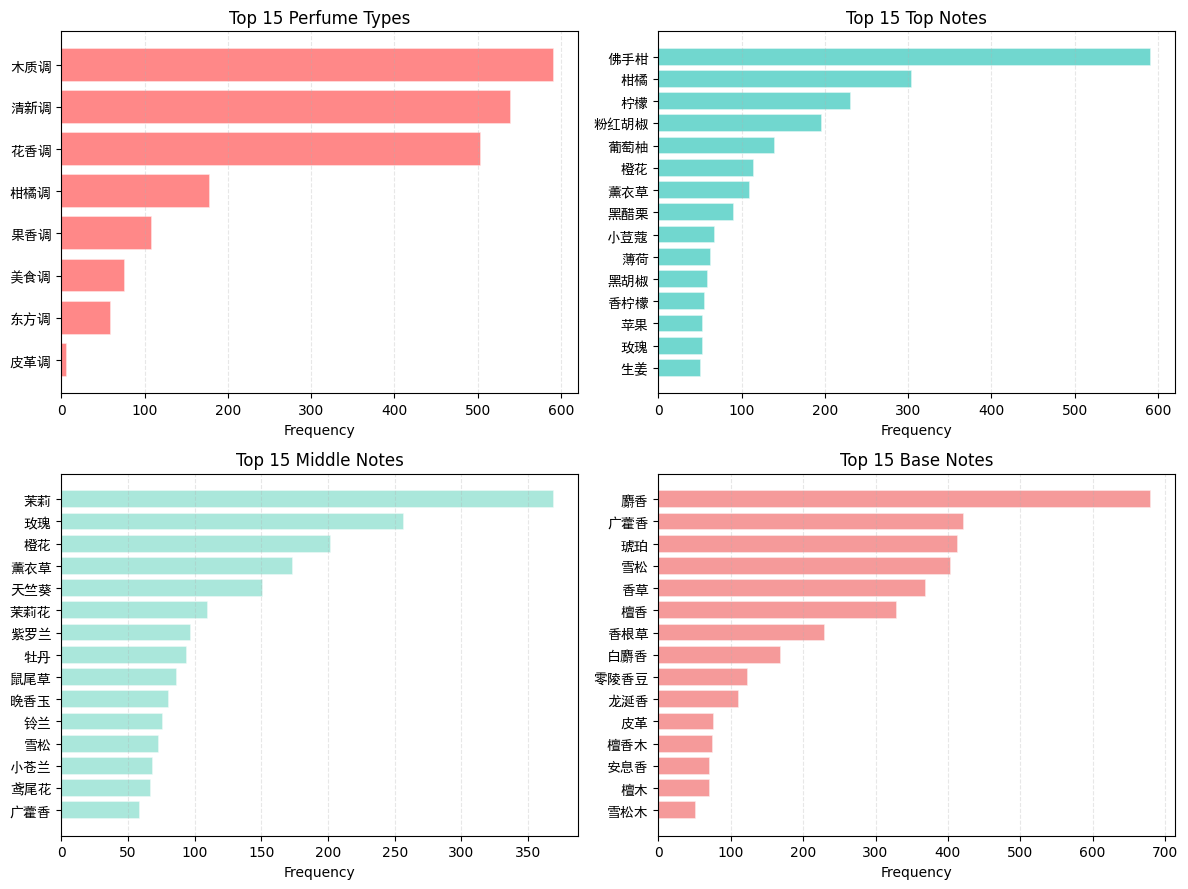

In [14]:
# Visualize most common notes
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# Color scheme for notes
note_colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#F38181']

# 1. Scent types Top 15
top_scents = scent_counter.most_common(15)
if top_scents:
    labels, values = zip(*top_scents)
    bars = axes[0, 0].barh(range(len(labels)), values, color=note_colors[0], 
                          alpha=0.8, edgecolor='white', linewidth=1.2)
    axes[0, 0].set_yticks(range(len(labels)))
    axes[0, 0].set_yticklabels(labels)
    axes[0, 0].set_title('Top 15 Perfume Types')
    axes[0, 0].set_xlabel('Frequency')
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(True, alpha=0.3, linestyle='--', axis='x')

# 2. Top notes Top 15
top_tops = top_counter.most_common(15)
if top_tops:
    labels, values = zip(*top_tops)
    bars = axes[0, 1].barh(range(len(labels)), values, color=note_colors[1], 
                          alpha=0.8, edgecolor='white', linewidth=1.2)
    axes[0, 1].set_yticks(range(len(labels)))
    axes[0, 1].set_yticklabels(labels)
    axes[0, 1].set_title('Top 15 Top Notes')
    axes[0, 1].set_xlabel('Frequency')
    axes[0, 1].invert_yaxis()
    axes[0, 1].grid(True, alpha=0.3, linestyle='--', axis='x')

# 3. Middle notes Top 15
top_middles = middle_counter.most_common(15)
if top_middles:
    labels, values = zip(*top_middles)
    bars = axes[1, 0].barh(range(len(labels)), values, color=note_colors[2], 
                          alpha=0.8, edgecolor='white', linewidth=1.2)
    axes[1, 0].set_yticks(range(len(labels)))
    axes[1, 0].set_yticklabels(labels)
    axes[1, 0].set_title('Top 15 Middle Notes')
    axes[1, 0].set_xlabel('Frequency')
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(True, alpha=0.3, linestyle='--', axis='x')

# 4. Base notes Top 15
top_bases = base_counter.most_common(15)
if top_bases:
    labels, values = zip(*top_bases)
    bars = axes[1, 1].barh(range(len(labels)), values, color=note_colors[3], 
                          alpha=0.8, edgecolor='white', linewidth=1.2)
    axes[1, 1].set_yticks(range(len(labels)))
    axes[1, 1].set_yticklabels(labels)
    axes[1, 1].set_title('Top 15 Base Notes')
    axes[1, 1].set_xlabel('Frequency')
    axes[1, 1].invert_yaxis()
    axes[1, 1].grid(True, alpha=0.3, linestyle='--', axis='x')

plt.tight_layout()
plt.savefig('img/notes_analysis.png', dpi=300)
plt.show()

In [15]:
# Extract brand from product name
def extract_brand(name):
    """Extract brand name (first word or Chinese word)"""
    if pd.isna(name):
        return 'Unknown'
    # Try to match English brand name (first word)
    match = re.match(r'^([A-Za-z&\s\']+)', str(name))
    if match:
        return match.group(1).strip()
    return 'Other'

df['brand'] = df['name'].apply(extract_brand)

# Brand statistics
brand_counts = df['brand'].value_counts().head(20)
brand_avg_price = df.groupby('brand')['special_price'].mean().sort_values(ascending=False).head(20)

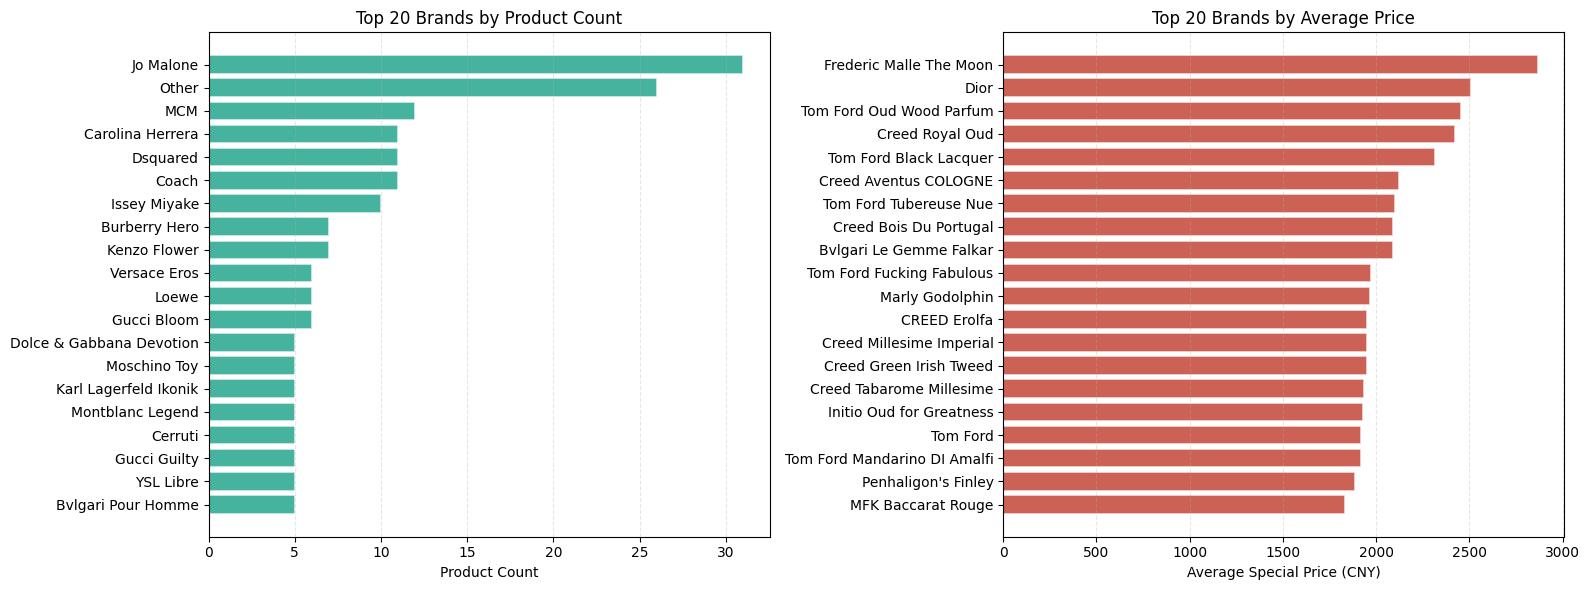

In [16]:
# Brand visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor('white')

# 1. Top 20 brands by product count
bars = axes[0].barh(range(len(brand_counts)), brand_counts.values, 
                    color='#16a085', alpha=0.8, edgecolor='white', linewidth=1.2)
axes[0].set_yticks(range(len(brand_counts)))
axes[0].set_yticklabels(brand_counts.index)
axes[0].set_title('Top 20 Brands by Product Count')
axes[0].set_xlabel('Product Count')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, linestyle='--', axis='x')

# 2. Top 20 brands by average price
bars = axes[1].barh(range(len(brand_avg_price)), brand_avg_price.values, 
                    color='#c0392b', alpha=0.8, edgecolor='white', linewidth=1.2)
axes[1].set_yticks(range(len(brand_avg_price)))
axes[1].set_yticklabels(brand_avg_price.index)
axes[1].set_title('Top 20 Brands by Average Price')
axes[1].set_xlabel('Average Special Price (CNY)')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, linestyle='--', axis='x')

plt.tight_layout()
plt.savefig('img/brand_analysis.png', dpi=300)
plt.show()

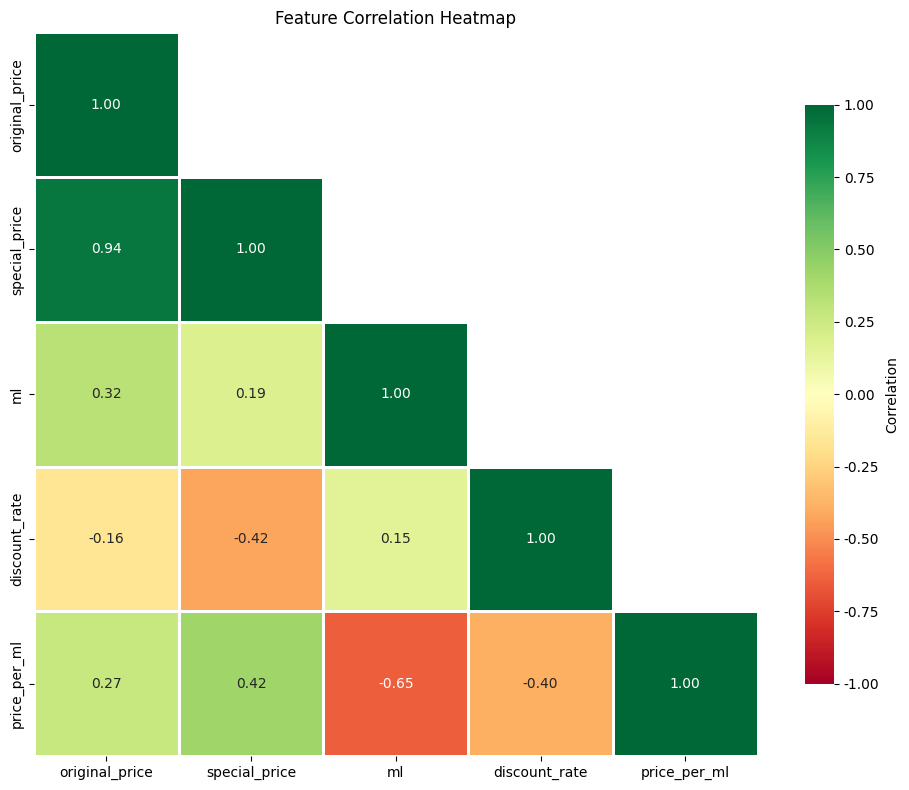

                original_price  special_price        ml  discount_rate  \
original_price        1.000000       0.936197  0.321814      -0.159392   
special_price         0.936197       1.000000  0.186648      -0.424715   
ml                    0.321814       0.186648  1.000000       0.154856   
discount_rate        -0.159392      -0.424715  0.154856       1.000000   
price_per_ml          0.271773       0.419857 -0.646151      -0.397313   

                price_per_ml  
original_price      0.271773  
special_price       0.419857  
ml                 -0.646151  
discount_rate      -0.397313  
price_per_ml        1.000000  


In [17]:
# Calculate correlation matrix for numeric variables
correlation_cols = ['original_price', 'special_price', 'ml', 'discount_rate', 'price_per_ml']
corr_matrix = df[correlation_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8), facecolor='white')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, 
            square=True, linewidths=2, cbar_kws={"shrink": 0.8, "label": "Correlation"},
            fmt='.2f', vmin=-1, vmax=1, mask=mask,)
plt.title('Feature Correlation Heatmap')

plt.tight_layout()
plt.savefig('img/correlation_heatmap.png', dpi=300)
plt.show()

print(corr_matrix)

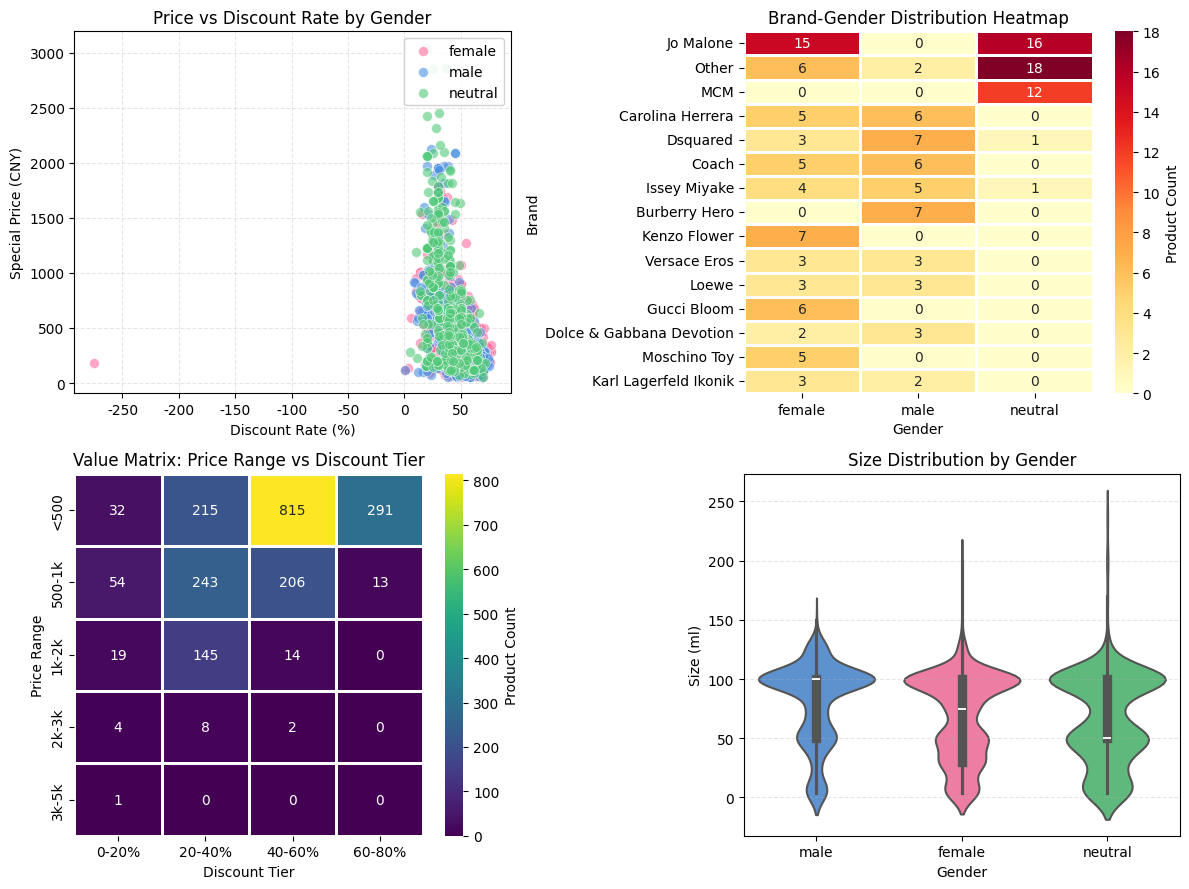

In [ ]:
# 1. Price vs Discount Rate Scatter Plot (with Gender coloring)
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
fig.patch.set_facecolor('white')

# Price vs Discount scatter
gender_colors = {'female': '#FF6B9D', 'male': '#4A90E2', 'neutral': '#50C878'}
for gender in ['female', 'male', 'neutral']:
    data = df[(df['gender'] == gender) & df['discount_rate'].notna() & df['special_price'].notna()]
    axes[0, 0].scatter(data['discount_rate'], data['special_price'], 
                      alpha=0.6, s=50, label=gender, color=gender_colors[gender], 
                      edgecolors='white', linewidths=0.5)
axes[0, 0].set_title('Price vs Discount Rate by Gender')
axes[0, 0].set_xlabel('Discount Rate (%)')
axes[0, 0].set_ylabel('Special Price (CNY)')
axes[0, 0].legend(framealpha=0.9, loc='upper right')
axes[0, 0].grid(True, alpha=0.3, linestyle='--')

# 2. Brand-Gender Heatmap
brand_gender = pd.crosstab(df['brand'], df['gender'])
top_brands = df['brand'].value_counts().head(15).index
brand_gender_filtered = brand_gender.loc[top_brands]
sns.heatmap(brand_gender_filtered, annot=True, fmt='d', cmap='YlOrRd', ax=axes[0, 1],
            cbar_kws={'label': 'Product Count'}, linewidths=1, linecolor='white')
axes[0, 1].set_title('Brand-Gender Distribution Heatmap')
axes[0, 1].set_xlabel('Gender')
axes[0, 1].set_ylabel('Brand')

# 3. Value Score Matrix (Price Tier vs Discount Range)
df['discount_tier'] = pd.cut(df['discount_rate'], bins=[0, 20, 40, 60, 80, 100], 
                              labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'])
value_matrix = pd.crosstab(df.get('price_range', pd.Series()), df['discount_tier'])
if not value_matrix.empty:
    sns.heatmap(value_matrix, annot=True, fmt='d', cmap='viridis', ax=axes[1, 0],
                cbar_kws={'label': 'Product Count'}, linewidths=1, linecolor='white')
    axes[1, 0].set_title('Value Matrix: Price Range vs Discount Tier')
    axes[1, 0].set_xlabel('Discount Tier')
    axes[1, 0].set_ylabel('Price Range')

# 4. Size Distribution by Gender (violin plot)
df_plot = df[df['ml'].notna()]
sns.violinplot(data=df_plot, x='gender', y='ml', ax=axes[1, 1], 
               palette=gender_colors, inner='box', linewidth=1.5)
axes[1, 1].set_title('Size Distribution by Gender')
axes[1, 1].set_xlabel('Gender')
axes[1, 1].set_ylabel('Size (ml)')
axes[1, 1].grid(True, alpha=0.3, linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('img/advanced_multidimalesional_analysis.png', dpi=300)
plt.show()

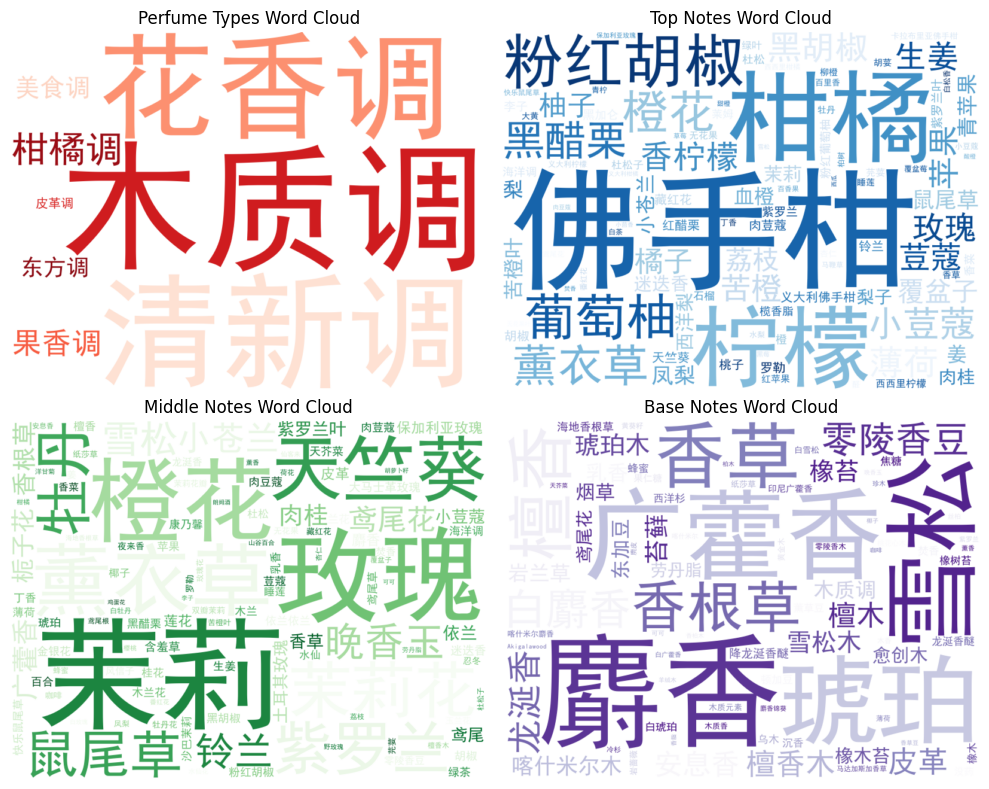

In [19]:
# Create word clouds for fragrance notes
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Custom color functions for different note types
def color_func_scent(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl({np.random.randint(0, 30)}, 80%, 50%)"

def color_func_top(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl({np.random.randint(150, 200)}, 70%, 50%)"

def color_func_middle(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl({np.random.randint(80, 130)}, 75%, 50%)"

def color_func_base(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl({np.random.randint(280, 330)}, 65%, 50%)"

# 1. Scent types word cloud
if scent_counter:
    wordcloud_scent = WordCloud(width=800, height=600, background_color='white',
                                 font_path='C:/Windows/Fonts/simhei.ttf',
                                 colormap='Reds', relative_scaling=0.5,
                                 min_font_size=10).generate_from_frequencies(scent_counter)
    axes[0, 0].imshow(wordcloud_scent, interpolation='bilinear')
    axes[0, 0].set_title('Perfume Types Word Cloud')
    axes[0, 0].axis('off')

# 2. Top notes word cloud
if top_counter:
    wordcloud_top = WordCloud(width=800, height=600, background_color='white',
                              font_path='C:/Windows/Fonts/simhei.ttf',
                              colormap='Blues', relative_scaling=0.5,
                              min_font_size=10).generate_from_frequencies(top_counter)
    axes[0, 1].imshow(wordcloud_top, interpolation='bilinear')
    axes[0, 1].set_title('Top Notes Word Cloud')
    axes[0, 1].axis('off')

# 3. Middle notes word cloud
if middle_counter:
    wordcloud_middle = WordCloud(width=800, height=600, background_color='white',
                                 font_path='C:/Windows/Fonts/simhei.ttf',
                                 colormap='Greens', relative_scaling=0.5,
                                 min_font_size=10).generate_from_frequencies(middle_counter)
    axes[1, 0].imshow(wordcloud_middle, interpolation='bilinear')
    axes[1, 0].set_title('Middle Notes Word Cloud')
    axes[1, 0].axis('off')

# 4. Base notes word cloud
if base_counter:
    wordcloud_base = WordCloud(width=800, height=600, background_color='white',
                               font_path='C:/Windows/Fonts/simhei.ttf',
                               colormap='Purples', relative_scaling=0.5,
                               min_font_size=10).generate_from_frequencies(base_counter)
    axes[1, 1].imshow(wordcloud_base, interpolation='bilinear')
    axes[1, 1].set_title('Base Notes Word Cloud')
    axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('img/wordcloud_analysis.png', dpi=300)
plt.show()

In [20]:
# Create Sankey diagram: Brand -> Price Range -> Gender
# Prepare data for Sankey diagram
df_sankey = df[df['brand'].notna() & df['price_range'].notna() & df['gender'].notna()].copy()

# Get top 10 brands
top_10_brands = df_sankey['brand'].value_counts().head(10).index
df_sankey_filtered = df_sankey[df_sankey['brand'].isin(top_10_brands)]

# Count flows
flow_data = df_sankey_filtered.groupby(['brand', 'price_range', 'gender']).size().reset_index(name='count')

# Create node labels
brands = sorted(flow_data['brand'].unique().tolist())
price_ranges = sorted(flow_data['price_range'].unique().tolist(), 
                      key=lambda x: ['<500', '500-1k', '1k-2k', '2k-3k', '3k-5k', '5k-10k', '>10k'].index(x) if x in ['<500', '500-1k', '1k-2k', '2k-3k', '3k-5k', '5k-10k', '>10k'] else 0)
genders = sorted(flow_data['gender'].unique().tolist())

all_nodes = brands + price_ranges + genders

# Create node indices
node_dict = {node: idx for idx, node in enumerate(all_nodes)}

# Create source, target, value lists
sources = []
targets = []
values = []
colors = []

# Brand -> Price Range
for _, row in flow_data.groupby(['brand', 'price_range'])['count'].sum().reset_index().iterrows():
    sources.append(node_dict[row['brand']])
    targets.append(node_dict[row['price_range']])
    values.append(row['count'])
    colors.append('rgba(100, 150, 200, 0.4)')

# Price Range -> Gender
for _, row in flow_data.groupby(['price_range', 'gender'])['count'].sum().reset_index().iterrows():
    sources.append(node_dict[row['price_range']])
    targets.append(node_dict[row['gender']])
    values.append(row['count'])
    colors.append('rgba(200, 100, 150, 0.4)')

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='white', width=2),
        label=all_nodes,
        color=['#3498db']*len(brands) + ['#2ecc71']*len(price_ranges) + ['#e74c3c']*len(genders)
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=colors
    )
)])

fig.update_layout(
    title={
        'text': "Brand → Price Range → Gender Flow Analysis",
        'font': {'size': 20, 'family': 'Arial', 'color': '#2c3e50'},
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(size=12, family='Arial'),
    plot_bgcolor='white',
    paper_bgcolor='white',
    height=800,
    margin=dict(l=20, r=20, t=80, b=20)
)

fig.write_image("img/Brand_PriceRange_Gender_Sankey.png", scale=2)
fig.show()

In [ ]:
# Create recommaledation features
def create_recommaledation_features(df):
    """Create features for recommaledation system"""
    df_rec = df.copy()
    
    # 1. Price tier classification
    df_rec['price_tier'] = pd.cut(df_rec['special_price'], 
                                    bins=[0, 500, 1000, 2000, 5000, 100000],
                                    labels=['Budget', 'Affordable', 'Mid-range', 'Premium', 'Luxury'])
    
    # 2. Value score (discount rate / normalized unit price)
    df_rec['value_score'] = (df_rec['discount_rate'] / 100) * (1 - df_rec['price_per_ml'] / df_rec['price_per_ml'].max())
    
    # 3. Has fragrance notes information
    df_rec['has_notes'] = df_rec.apply(lambda x: 
        1 if (pd.notna(x['fragrance']) and x['fragrance'] != '未提供') else 0, axis=1)
    
    # 4. Description length (may reflect product quality/popularity)
    df_rec['desc_length'] = df_rec['description'].apply(lambda x: len(str(x)) if pd.notna(x) and x != '未提供' else 0)
    
    # 5. Common size indicator
    common_sizes = df_rec['ml'].value_counts().head(5).index.tolist()
    df_rec['is_common_size'] = df_rec['ml'].apply(lambda x: 1 if x in common_sizes else 0)
    
    return df_rec

df_rec = create_recommaledation_features(df)

In [21]:
df_tree = df[df['brand'].notna() & df['gender'].notna()].copy()
top_15_brands = df_tree['brand'].value_counts().head(15).index
df_tree_filtered = df_tree[df_tree['brand'].isin(top_15_brands)]

tree_data = df_tree_filtered.groupby(['gender', 'brand']).size().reset_index(name='count')

fig_tree = px.treemap(tree_data, 
                      path=['gender', 'brand'], 
                      values='count',
                      title='Product Distribution: Gender → Brand (Treemap)',
                      color='count',
                      color_continuous_scale='RdYlGn',
                      labels={'count': 'Product Count'})

fig_tree.update_layout(
    font=dict(size=14, family='Arial'),
    title_font=dict(size=20, family='Arial', color='#2c3e50'),
    title_x=0.5,
    height=700,
    margin=dict(l=10, r=10, t=80, b=10)
)

fig_tree.write_image("img/Treemap_Gender_Brand.png", scale=2)
fig_tree.show()

In [29]:
df_sun = df_rec[df_rec['brand'].notna() & df_rec['price_tier'].notna() & df_rec['gender'].notna()].copy()
top_12_brands = df_sun['brand'].value_counts().head(12).index
df_sun_filtered = df_sun[df_sun['brand'].isin(top_12_brands)]

sun_data = df_sun_filtered.groupby(['gender', 'price_tier', 'brand']).size().reset_index(name='count')

fig_sun = px.sunburst(sun_data,
                      path=['gender', 'price_tier', 'brand'],
                      values='count',
                      title='Product Hierarchy: Gender → Price Tier → Brand (Sunburst)',
                      color='count',
                      color_continuous_scale='Viridis')

fig_sun.update_layout(
    font=dict(size=12, family='Arial'),
    title_font=dict(size=20, family='Arial', color='#000000'),
    title_x=0.5,
    height=800,
    margin=dict(l=10, r=10, t=80, b=10)
)

# fig_sun.write_html('sunburst_visualization.html')
fig_sun.write_image("img/Sunburst_Gender_PriceTier_Brand.png", scale=2)
fig_sun.show()

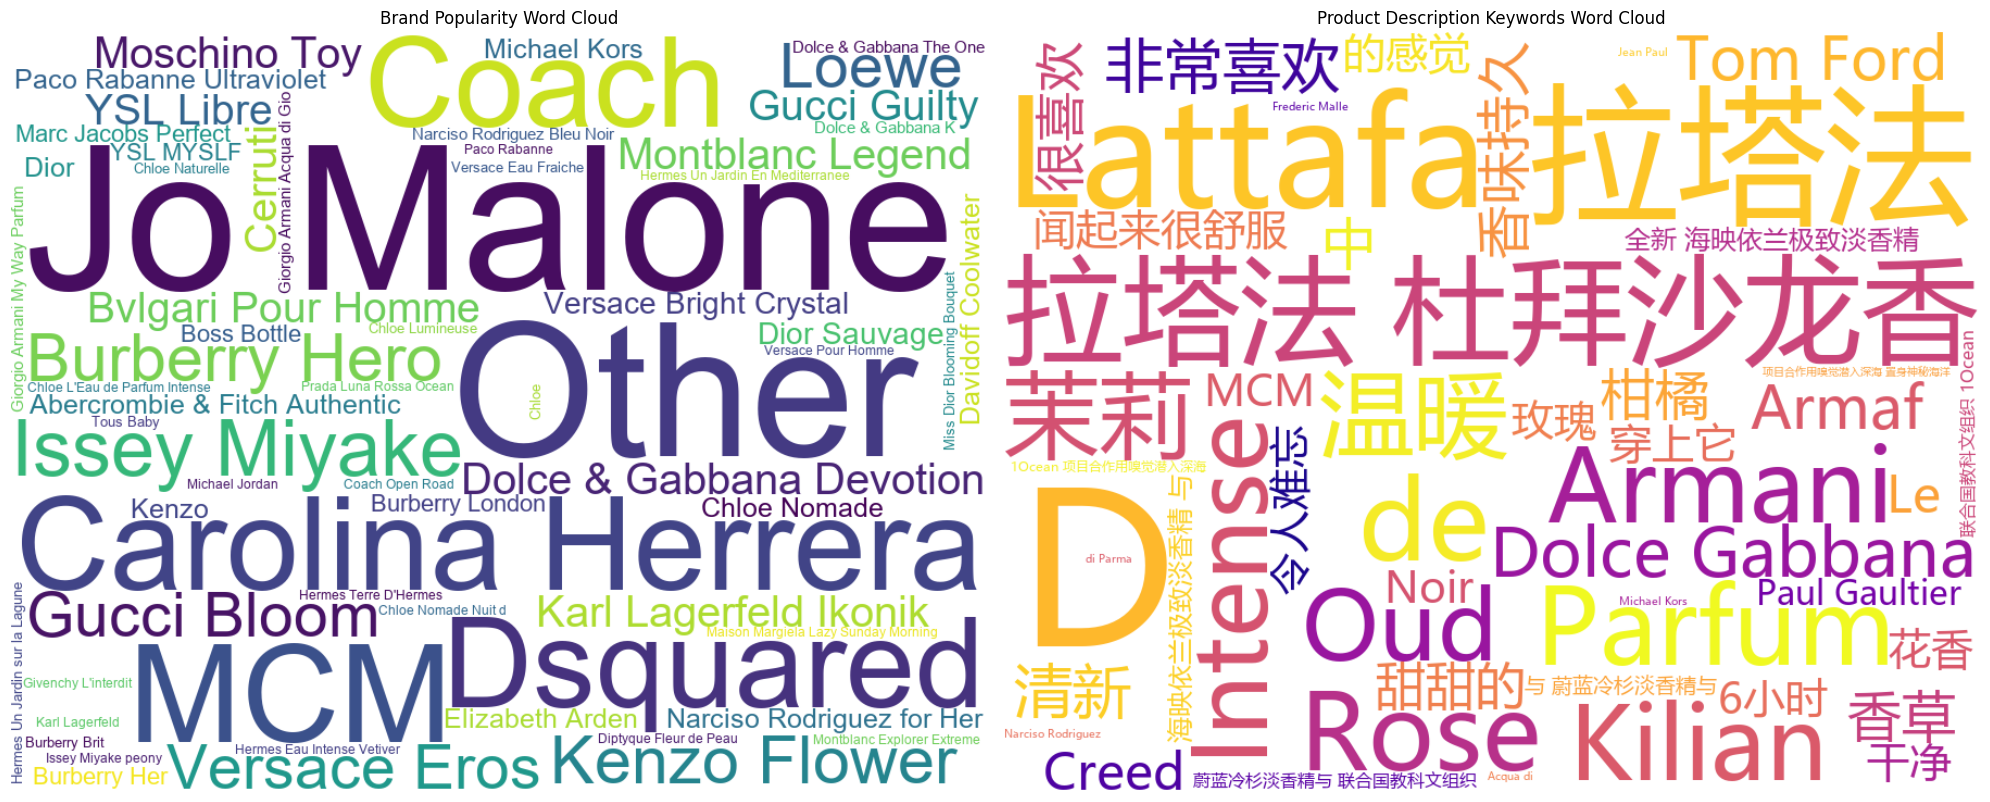

In [ ]:
# Brand Word Cloud
brand_freq = df['brand'].value_counts().to_dict()

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Brand word cloud
if brand_freq:
    wordcloud_brand = WordCloud(width=900, height=700, background_color='white',
                               font_path='C:/Windows/Fonts/arial.ttf',
                               colormap='viridis', relative_scaling=0.5,
                               min_font_size=12, max_words=100).generate_from_frequencies(brand_freq)
    axes[0].imshow(wordcloud_brand, interpolation='bilinear')
    axes[0].set_title('Brand Popularity Word Cloud')
    axes[0].axis('off')

# Description length word cloud (top keywords from descriptions)
desc_text = ' '.join(df['description'].dropna().astype(str).tolist())
if desc_text:
    wordcloud_desc = WordCloud(width=900, height=700, background_color='white',
                              font_path='C:/Windows/Fonts/msyh.ttc',
                              colormap='plasma', relative_scaling=0.5,
                              min_font_size=10, max_words=80).generate(desc_text)
    axes[1].imshow(wordcloud_desc, interpolation='bilinear')
    axes[1].set_title('Product Description Keywords Word Cloud')
    axes[1].axis('off')

plt.tight_layout()
plt.savefig('img/brand_description_wordcloud.png', dpi=300)
plt.show()

In [ ]:
df_3d = df[(df['special_price'].notna()) & 
           (df['ml'].notna()) & 
           (df['discount_rate'].notna()) &
           (df['gender'].notna())].copy()

# Sample data if too large
if len(df_3d) > 1000:
    df_3d = df_3d.sample(n=1000, random_state=42)

fig_3d = px.scatter_3d(df_3d, 
                       x='ml', 
                       y='special_price', 
                       z='discount_rate',
                       color='gender',
                       size='price_per_ml',
                       hover_data=['brand', 'name'],
                       title='3D Analysis: Size × Price × Discount Rate',
                       labels={
                           'ml': 'Size (ml)',
                           'special_price': 'Special Price (CNY)',
                           'discount_rate': 'Discount Rate (%)',
                           'gender': 'Gender',
                           'price_per_ml': 'Price per ML'
                       },
                       color_discrete_map={'female': '#FF6B9D', 'male': '#4A90E2', 'neutral': '#50C878'})

fig_3d.update_layout(
    font=dict(size=12, family='Arial'),
    title_font=dict(size=20, family='Arial', color='#2c3e50'),
    title_x=0.5,
    height=800,
    scene=dict(
        xaxis=dict(backgroundcolor='#f8f9fa', gridcolor='white', title_font=dict(size=14)),
        yaxis=dict(backgroundcolor='#f8f9fa', gridcolor='white', title_font=dict(size=14)),
        zaxis=dict(backgroundcolor='#f8f9fa', gridcolor='white', title_font=dict(size=14))
    ),
    margin=dict(l=0, r=0, t=80, b=0)
)

# fig_3d.write_html('3d_scatter_plot.html')
fig_3d.write_image("img/3D_Scatter_Plot_Size_Price_Discount.png", scale=2)
fig_3d.show()

In [ ]:
# Create recommaledation features
def create_recommaledation_features(df):
    """Create features for recommaledation system"""
    df_rec = df.copy()
    
    # 1. Price tier classification
    df_rec['price_tier'] = pd.cut(df_rec['special_price'], 
                                    bins=[0, 500, 1000, 2000, 5000, 100000],
                                    labels=['Budget', 'Affordable', 'Mid-range', 'Premium', 'Luxury'])
    
    # 2. Value score (discount rate / normalized unit price)
    df_rec['value_score'] = (df_rec['discount_rate'] / 100) * (1 - df_rec['price_per_ml'] / df_rec['price_per_ml'].max())
    
    # 3. Has fragrance notes information
    df_rec['has_notes'] = df_rec.apply(lambda x: 
        1 if (pd.notna(x['fragrance']) and x['fragrance'] != '未提供') else 0, axis=1)
    
    # 4. Description length (may reflect product quality/popularity)
    df_rec['desc_length'] = df_rec['description'].apply(lambda x: len(str(x)) if pd.notna(x) and x != '未提供' else 0)
    
    # 5. Common size indicator
    common_sizes = df_rec['ml'].value_counts().head(5).index.tolist()
    df_rec['is_common_size'] = df_rec['ml'].apply(lambda x: 1 if x in common_sizes else 0)
    
    return df_rec

df_rec = create_recommaledation_features(df)

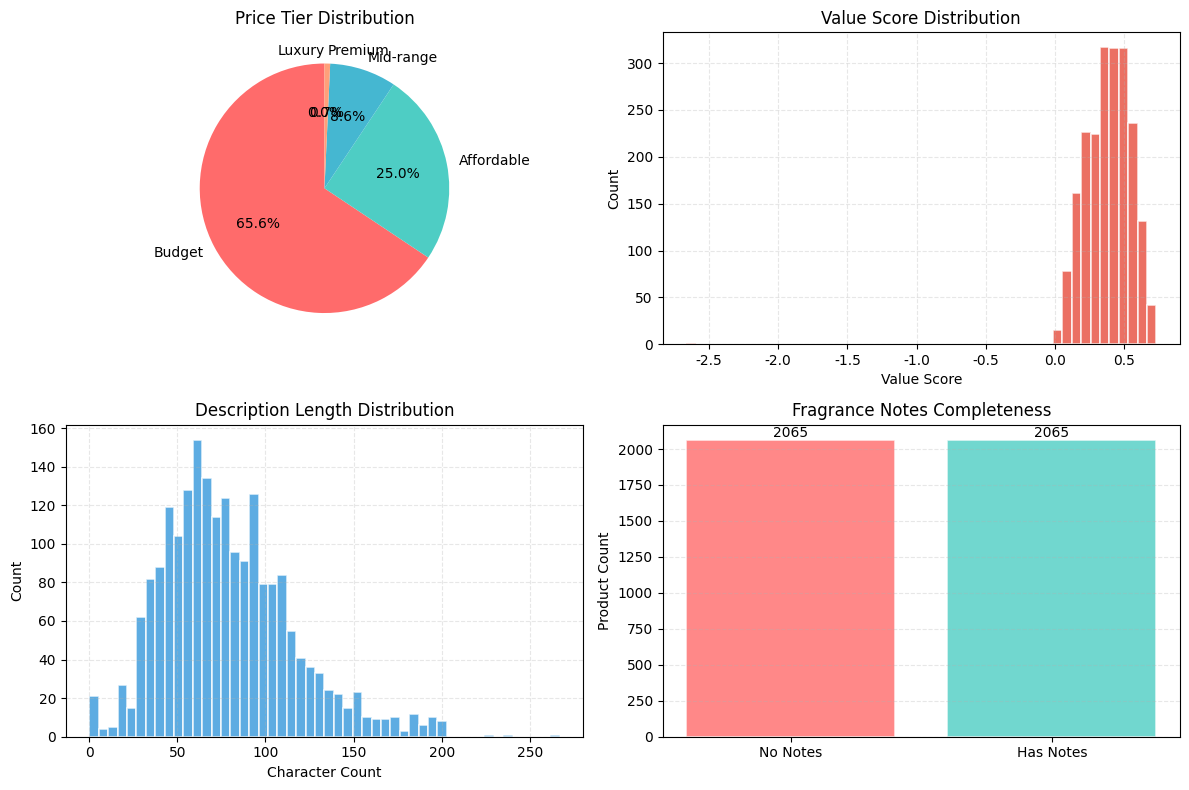

In [37]:
# View feature distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.patch.set_facecolor('white')

# 1. Price tier distribution
price_tier_counts = df_rec['price_tier'].value_counts()
colors_pie = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
axes[0, 0].pie(price_tier_counts.values, labels=price_tier_counts.index, autopct='%1.1f%%', 
               colors=colors_pie, startangle=90)
axes[0, 0].set_title('Price Tier Distribution')

# 2. Value score distribution
axes[0, 1].hist(df_rec['value_score'].dropna(), bins=50, color='#e74c3c', 
                edgecolor='white', alpha=0.8, linewidth=1.2)
axes[0, 1].set_title('Value Score Distribution')
axes[0, 1].set_xlabel('Value Score')
axes[0, 1].set_ylabel('Count')
axes[0, 1].grid(True, alpha=0.3, linestyle='--')

# 3. Description length distribution
axes[1, 0].hist(df_rec['desc_length'], bins=50, color='#3498db', 
                edgecolor='white', alpha=0.8, linewidth=1.2)
axes[1, 0].set_title('Description Length Distribution')
axes[1, 0].set_xlabel('Character Count')
axes[1, 0].set_ylabel('Count')
axes[1, 0].grid(True, alpha=0.3, linestyle='--')

# 4. Fragrance notes completeness
has_notes_counts = df_rec['has_notes'].value_counts()
bars = axes[1, 1].bar(['No Notes', 'Has Notes'], has_notes_counts.values, 
                      color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='white', linewidth=1.2)
axes[1, 1].set_title('Fragrance Notes Completeness')
axes[1, 1].set_ylabel('Product Count')
axes[1, 1].grid(True, alpha=0.3, linestyle='--', axis='y')
# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('img/feature_engineering.png', dpi=300)
plt.show()

In [45]:
df_rec['recommendation_score'] = (
    df_rec['discount_rate'].fillna(0) / 100 * 0.3 +  # Discount weight 30%
    (1 - df_rec['price_per_ml'].fillna(df_rec['price_per_ml'].max()) / df_rec['price_per_ml'].max()) * 0.4 +  # Unit price weight 40%
    df_rec['has_notes'] * 0.3  # Notes info weight 30%
)

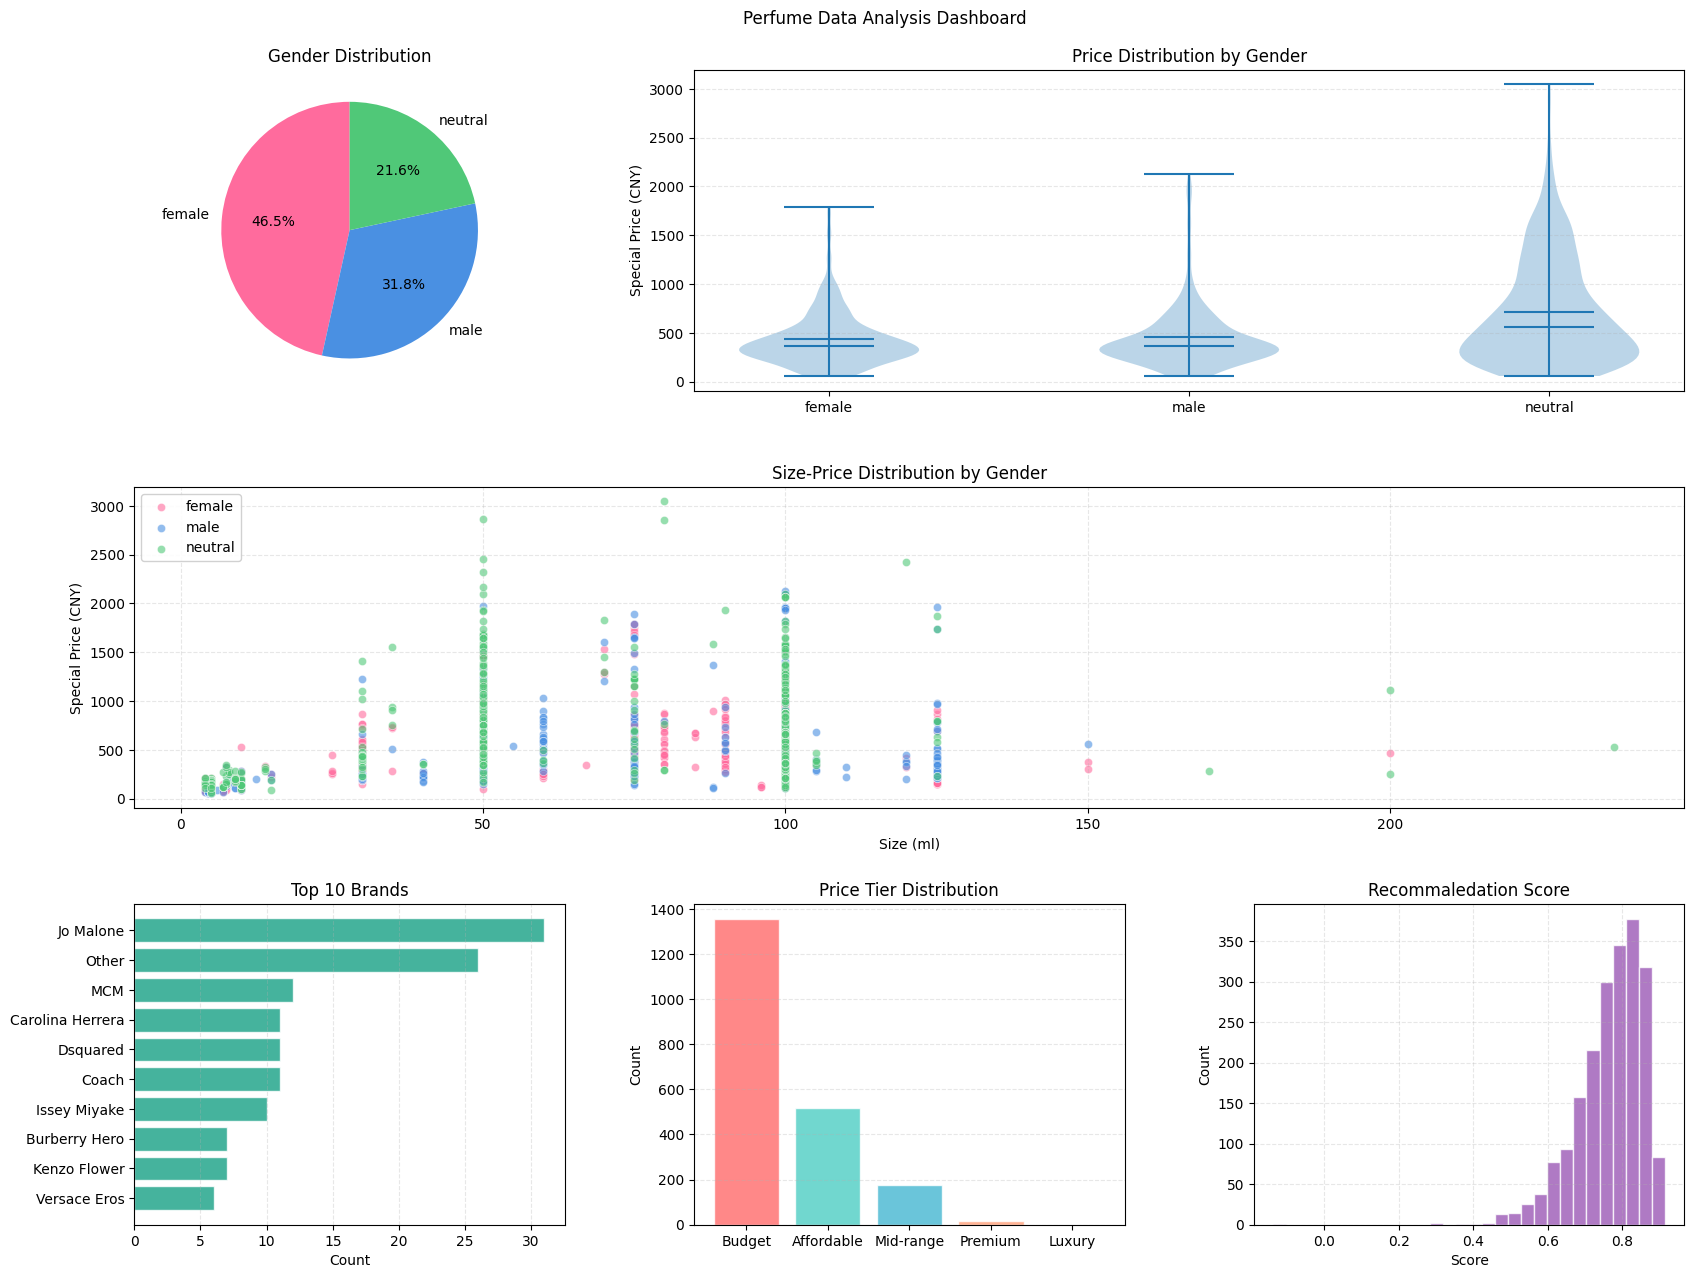

In [63]:
# Create comprehensive dashboard
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

gender_colors_dash = {'female': '#FF6B9D', 'male': '#4A90E2', 'neutral': '#50C878'}

# 1. Gender distribution
ax1 = fig.add_subplot(gs[0, 0])
gender_counts = df['gender'].value_counts()
colors_gender = [gender_colors_dash[g] for g in gender_counts.index]
ax1.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', 
    startangle=90, colors=colors_gender)
ax1.set_title('Gender Distribution')

# 2. Price distribution violin plot
ax2 = fig.add_subplot(gs[0, 1:])
parts = ax2.violinplot([df[df['gender']==g]['special_price'].dropna() for g in ['female', 'male', 'neutral']],
               positions=[0, 1, 2], showmeans=True, showmedians=True)
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['female', 'male', 'neutral'])
ax2.set_title('Price Distribution by Gender')
ax2.set_ylabel('Special Price (CNY)')
ax2.grid(True, alpha=0.3, linestyle='--', axis='y')

# 3. Price-Size scatter plot (by gender)
ax3 = fig.add_subplot(gs[1, :])
for gender in ['female', 'male', 'neutral']:
    data = df[(df['gender'] == gender) & df['ml'].notna() & df['special_price'].notna()]
    ax3.scatter(data['ml'], data['special_price'], alpha=0.6, s=35, 
           label=gender, color=gender_colors_dash[gender], edgecolors='white', linewidths=0.5)
ax3.set_xlabel('Size (ml)')
ax3.set_ylabel('Special Price (CNY)')
ax3.set_title('Size-Price Distribution by Gender')
ax3.legend(framealpha=0.9, loc='upper left')
ax3.grid(True, alpha=0.3, linestyle='--')

# 4. Top brands
ax4 = fig.add_subplot(gs[2, 0])
top_brands = df['brand'].value_counts().head(10)
bars = ax4.barh(range(len(top_brands)), top_brands.values, color='#16a085', 
           alpha=0.8, edgecolor='white', linewidth=1)
ax4.set_yticks(range(len(top_brands)))
ax4.set_yticklabels(top_brands.index)
ax4.set_title('Top 10 Brands')
ax4.set_xlabel('Count')
ax4.invert_yaxis()
ax4.grid(True, alpha=0.3, linestyle='--', axis='x')

# 5. Price tier
ax5 = fig.add_subplot(gs[2, 1])
price_tier_counts = df_rec['price_tier'].value_counts().sort_index()
bars = ax5.bar(range(len(price_tier_counts)), price_tier_counts.values, 
          color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'], alpha=0.8, 
          edgecolor='white', linewidth=1)
ax5.set_xticks(range(len(price_tier_counts)))
ax5.set_xticklabels(price_tier_counts.index)
ax5.set_title('Price Tier Distribution')
ax5.set_ylabel('Count')
ax5.grid(True, alpha=0.3, linestyle='--', axis='y')

# 6. Recommaledation score distribution
ax6 = fig.add_subplot(gs[2, 2])
ax6.hist(df_rec['recommendation_score'].dropna(), bins=30, color='#9b59b6', 
    alpha=0.8, edgecolor='white', linewidth=1)
ax6.set_title('Recommaledation Score')
ax6.set_xlabel('Score')
ax6.set_ylabel('Count')
ax6.grid(True, alpha=0.3, linestyle='--')

# Move the main title down to reduce whitespace
plt.suptitle('Perfume Data Analysis Dashboard', y=0.92)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('img/comprehensive_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()
